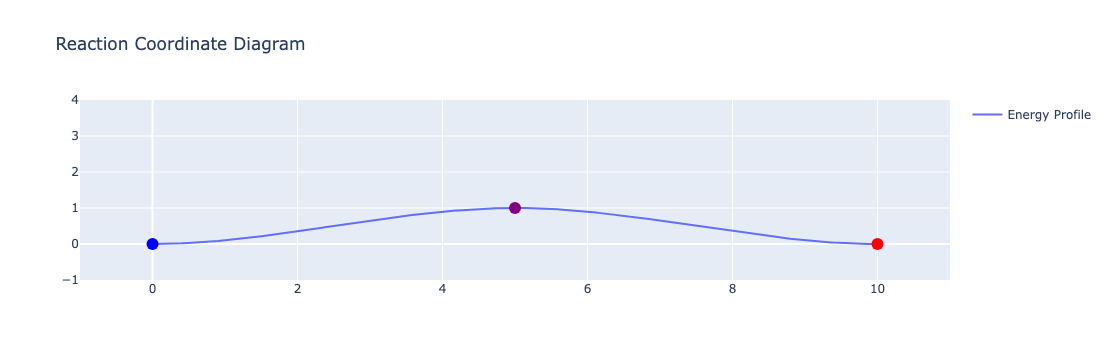

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import Button
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap  # Import LinearSegmentedColormap

# Remove the toolbar
#  matplotlib.rcParams['toolbar'] = 'None'

# Track the state of Shift key presses
shift_pressed = False

# Define the color spectrum as per your description
color_list = [
    "#9000FF",  # purple
    "#FB00FF",  # purple
    "#002AFF",  # blue    
    "#00BBFF",  # blue
    "#037303",  # green    
    "#03E203",  # green
    '#FFFF00',  # yellow
    "#F6B132",  # orange
    '#FF0000',  # red
    "#6A0202"   # dark red
]
cm = mcolors.LinearSegmentedColormap.from_list("DeltaHColors", color_list)

# Create a smooth gradient colormap
cmap = LinearSegmentedColormap.from_list("spectrum", color_list, N=256)

# Define the range for ΔH
deltaH_min = -5  # large exothermic (negative)
deltaH_max = 5   # large endothermic (positive)


# Initialize energies
reactant_energy = 10
product_energy = 10
activation_energy = 1.4

labels_visible = True
button_is_on = True

endothermic_mode = False  # Default mode is not endothermic
exothermic_mode = False # Default mode is not exothermic
# Default starting positions for endothermic mode
ENDOTHERMIC_REACTANT_ENERGY = 10  # Fixed reactant energy
ENDOTHERMIC_PRODUCT_ENERGY = 12   # Initial product energy
ENDOTHERMIC_PEAK_ENERGY = 13.55      # Initial transition state energy
# Default starting positions for exothermic mode
EXOTHERMIC_REACTANT_ENERGY = 10  # Fixed reactant energy
EXOTHERMIC_PRODUCT_ENERGY = 8    # Initial product energy
EXOTHERMIC_PEAK_ENERGY = 11.4      # Initial transition state energy

initial_max_energy = max(ENDOTHERMIC_REACTANT_ENERGY, ENDOTHERMIC_PRODUCT_ENERGY, ENDOTHERMIC_PEAK_ENERGY)
initial_min_energy = min(ENDOTHERMIC_REACTANT_ENERGY, ENDOTHERMIC_PRODUCT_ENERGY, ENDOTHERMIC_PEAK_ENERGY)

x = np.linspace(0, 10, 500)

# Transition state initial position
peak_x = 5
peak_y = reactant_energy + activation_energy

def cubic_with_conditions(x0, y0, x1, y1, x2, y2, slope0=0, slope2=0):
    A_full = np.array([
        [x0**3, x0**2, x0, 1],
        [3*x0**2, 2*x0, 1, 0],
        [x2**3, x2**2, x2, 1],
        [3*x2**2, 2*x2, 1, 0],
    ])
    b_full = np.array([y0, slope0, y2, slope2])
    coeffs = np.linalg.solve(A_full, b_full)
    return np.poly1d(coeffs)

def generate_left_segment():
    x_inflect = peak_x / 2
    y_inflect = (reactant_energy + peak_y) / 2
    return cubic_with_conditions(
        x0=0,
        y0=reactant_energy,
        x1=x_inflect,
        y1=y_inflect,
        x2=peak_x,
        y2=peak_y,
        slope0=0,
        slope2=0
    )

def generate_right_segment():
    x_inflect = peak_x + (x[-1] - peak_x) / 2
    y_inflect = (peak_y + product_energy) / 2
    return cubic_with_conditions(
        x0=peak_x,
        y0=peak_y,
        x1=x_inflect,
        y1=y_inflect,
        x2=x[-1],
        y2=product_energy,
        slope0=0,
        slope2=0
    )

def compute_energy():
    left_poly = generate_left_segment()
    right_poly = generate_right_segment()
    y_vals = np.empty_like(x)
    mask_left = x <= peak_x
    mask_right = x > peak_x
    y_vals[mask_left] = left_poly(x[mask_left])
    y_vals[mask_right] = right_poly(x[mask_right])
    return y_vals

# Plot setup
y_data = compute_energy()

fig, ax = plt.subplots()
line, = ax.plot(x, y_data, color='grey', lw=2)
ax.set_xlabel('Reaction Coordinate', fontweight='bold')
ax.set_ylabel('Energy', fontweight='bold')
ax.set_xlim(-1, 11)
ax.set_ylim(4, 18)
ax.set_title('Reaction Coordinate Diagram', fontweight="bold")

# Enable grid lines with faint gray color
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Set grid lines at 1-unit intervals
ax.set_xticks(np.arange(-1, 12, 1))
ax.set_yticks(np.arange(4, 19, 1))  # Adjusted to match y-axis limits (4 to 18)

def on_lims_change(event_ax):
    """
    Callback function to update gridlines when axis limits change.
    """
    # Enable grid lines with faint gray color
    event_ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    # Explicitly set gridline positions based on current axis limits
    x_min, x_max = event_ax.get_xlim()
    y_min, y_max = event_ax.get_ylim()

    # Set x-axis gridlines at 1-unit intervals
    event_ax.set_xticks(np.arange(np.floor(x_min), np.ceil(x_max) + 1, 1))

    # Set y-axis gridlines at 1-unit intervals
    event_ax.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 1, 1))

    # Redraw the plot
    plt.draw()

# Connect the callback function to the axis
ax.callbacks.connect('xlim_changed', on_lims_change)
ax.callbacks.connect('ylim_changed', on_lims_change)

# Manually call on_lims_change to initialize the grid lines properly
on_lims_change(ax)


# Draw dashed horizontal lines at energies
reactant_line = ax.axhline(reactant_energy, color='grey', linestyle='--')
product_line = ax.axhline(product_energy, color='grey', linestyle='--')
ts_line = ax.axhline(peak_y, color='grey', linestyle='--')

# Initialize variables to store the Ea arrow label and delta H label
ea_arrow = None
ea_label = None
show_ea = False
show_deltaH = False
deltaH_arrow = None
deltaH_label = None
BUTTON_PALE_GREEN = 'palegreen'
BUTTON_PALE_ORANGE = 'peachpuff'



# Initialize variables for saved curves
saved_curves = []  # List to store saved curves
color_sequence = ['green', 'orange', 'red']  # Color sequence for saved curves
color_index = 0  # Index to track the current color


# After your initial plot setup, add:
x_arrow_init = peak_x - 0.5
y_start_init = reactant_energy
y_end_init = peak_y
x_deltaH = peak_x + 0.5  # adjust as needed for visual clarity
y_start_deltaH = reactant_energy
y_end_deltaH = product_energy

# Transition state point (draggable)
peak_point, = ax.plot(peak_x, peak_y, 'o', markersize=12, picker=5)

# Define the color interpolation function early, after imports
def get_transition_color(peak_x):
    t = (peak_x - 1) / (9.9 - 0.1)
    t = np.clip(t, 0, 1)
    if t <= 0.5:
        t2 = t / 0.5
        r = 0 + t2 * 0.5
        g = 0
        b = 1 + t2 * (-0.5)
    else:
        t2 = (t - 0.5) / 0.5
        r = 0.5 + t2 * 0.5
        g = 0
        b = 0.5 + t2 * (-0.5)
    return r, g, b

# Set initial color based on the starting position
r, g, b = get_transition_color(peak_x)
initial_color = (r, g, b)  # assuming get_transition_color returns normalized [0,1]
peak_point.set_markerfacecolor(initial_color)
peak_point.set_markeredgecolor(initial_color)

# Reactant and product points (draggable)
reactant_point, = ax.plot(0, reactant_energy, 'o', color='blue', markersize=12, markerfacecolor='blue', picker=5)
product_point, = ax.plot(10, product_energy, 'o', color='red', markersize=12, markerfacecolor='red', picker=5)

# Keep track of which point is being dragged
dragging_point = None

# Reactant text label
reactant_label = ax.text(0, reactant_energy + 0.5, 'REACTANT', color='blue', weight='bold', ha='center', va='bottom', fontsize=10)

# Product text label
product_label = ax.text(10, product_energy - 0.5, 'PRODUCT', color='red', weight='bold', ha='center', va='top', fontsize=10)

# TS text label
ts_label = ax.text(peak_x, peak_y + 0.5, 'TRANSITION STATE', color='purple', weight='bold', ha='center', va='bottom', fontsize=10)

      
def update_plot():
    global reactant_point, product_point, peak_point, reactant_energy, product_energy, peak_y, peak_x, ea_arrow, ea_label, deltaH_arrow, deltaH_label

    if endothermic_mode:
        reactant_energy = ENDOTHERMIC_REACTANT_ENERGY  # Enforce fixed reactant energy
    elif exothermic_mode:
        reactant_energy = EXOTHERMIC_REACTANT_ENERGY  # Enforce fixed reactant energy

    # Compute delta_H for Hammond's postulate
    delta_H = product_energy - reactant_energy

    # Map delta_H to normalized value [-1, 1], clamp
    max_delta = 10  # Adjust this value based on your energy scale
    delta_clamped = np.clip(delta_H, -max_delta, max_delta)
    norm_delta = delta_clamped / max_delta

    # Map to position between 1 and 9
    peak_x = 5 + norm_delta * 4
    peak_x = np.clip(peak_x, 1, 9)  # Ensure peak_x stays within bounds

    # Recompute energy profile with updated position
    ynew = compute_energy()

    # Update the energy plot
    line.set_data(x, ynew)

    # Update TS position
    peak_point.set_xdata([peak_x])
    peak_point.set_ydata([peak_y])

    # Get interpolated color for transition state
    r, g, b = get_transition_color(peak_x)

    # Set the marker color
    peak_point.set_markerfacecolor((r, g, b))
    peak_point.set_markeredgecolor((r, g, b))

    # Keep reactant and product points connected to the energies
    reactant_point.set_xdata([0])
    reactant_point.set_ydata([reactant_energy])
    product_point.set_xdata([10])
    product_point.set_ydata([product_energy])

    # Dynamically adjust plot y-limits
    #ymin = min(reactant_energy, product_energy, peak_y) - 2  # Add padding
    #ymax = max(reactant_energy, product_energy, peak_y) + 2  # Add padding



    # Update the horizontal lines to match current energies
    reactant_line.set_ydata([reactant_point.get_ydata()[0]])
    product_line.set_ydata([product_point.get_ydata()[0]])
    ts_line.set_ydata([peak_point.get_ydata()[0]])

    # Update Ea arrow and label
    if ea_arrow is not None:
        ea_arrow.remove()
        ea_arrow = None
    if ea_label is not None:
        ea_label.remove()
        ea_label = None

    # Calculate arrow position just left of the peak (always define these variables)
    x_arrow = peak_x - 0.5  # Adjust x position of the arrow
    y_start = reactant_energy
    y_end = peak_y

    # Only create Ea arrow and label if show_ea is True
    if show_ea:
        ea_arrow = ax.annotate('', xy=(x_arrow, y_end), xytext=(x_arrow, y_start), arrowprops=dict(arrowstyle='<->', color='green', lw=2), visible=show_ea)
        ea_label = ax.text(x_arrow - 0.1, (y_start + y_end) / 2, r'$E_a$', color='green', weight='bold', ha='right', va='center', visible=show_ea)
    else:
        ea_arrow = None
        ea_label = None

    # Update ΔH arrow and label
    if deltaH_arrow is not None:
        deltaH_arrow.remove()
        deltaH_arrow = None
    if deltaH_label is not None:
        deltaH_label.remove()
        deltaH_label = None

    # Calculate arrow position just right of the peak (always define these variables)
    x_deltaH = peak_x + 0.5  # Adjust x position of the arrow
    y_start_deltaH = reactant_energy
    y_end_deltaH = product_energy

    # Only create ΔH arrow and label if show_deltaH is True
    if show_deltaH:
        deltaH_arrow = ax.annotate('', xy=(x_deltaH, y_end_deltaH), xytext=(x_deltaH, y_start_deltaH), arrowprops=dict(arrowstyle='<->', color='orange', lw=2), visible=show_deltaH)
        deltaH_label = ax.text(x_deltaH + 0.1, (y_start_deltaH + y_end_deltaH) / 2, r'$\Delta H$', color='orange', weight='bold', ha='left', va='center', visible=show_deltaH)
    else:
        deltaH_arrow = None
        deltaH_label = None

    reactant_label.set_x(0)
    reactant_label.set_y(reactant_energy + 0.5)  # adjust vertical offset as needed

    product_label.set_x(10)
    product_label.set_y(product_energy - 0.5)  # adjust vertical offset as needed

    # Update position of the label to stay above the transition state
    ts_label.set_x(peak_x)
    ts_label.set_y(peak_y + 0.5)

    # Match the label's color to the transition state icon's color
    r, g, b = get_transition_color(peak_x)
    ts_label.set_color((r, g, b))

    plt.draw()


# Function to toggle Ea arrow and label visibility
def toggle_ea(event):
    global show_ea
    show_ea = not show_ea
    update_plot()  # Call update_plot to recreate the arrow and label with updated values
    toggle_button.label.set_text('Hide Ea' if show_ea else 'Show Ea')
    # Redraw the button to reflect the color change  
    plt.draw()

# Function to toggle ΔH arrow and label visibility
def toggle_deltaH(event):
    global show_deltaH
    show_deltaH = not show_deltaH
    update_plot()  # Call update_plot to recreate the arrow and label with updated values
    toggle_deltaH_button.label.set_text('Hide ΔH' if show_deltaH else 'Show ΔH')
    # Change button color based on show_ea state
    plt.draw()

def save_curve(event):
    global color_index
    deltaH_value = product_energy - reactant_energy
    curve_color = get_color_for_deltaH(deltaH_value)

    # Plot with the dynamic color
    saved_curve, = ax.plot(x, compute_energy(), color=curve_color, lw=2)
    saved_curves.append(saved_curve)

    # Calculate variables for Ea arrow and label if needed
    x_arrow = peak_x - 0.5  # Re-calculate the arrow position based on peak_x
    y_start = reactant_energy
    y_end = peak_y

    # Check if Shift (or Control) is pressed to save Ea arrow
    if shift_pressed:
        # Save Ea arrow and label along with the curve
        saved_ea_arrow = ax.annotate(
            '', xy=(x_arrow, y_end), xytext=(x_arrow, y_start),
            arrowprops=dict(arrowstyle='<->', color=curve_color, lw=2)
        )
        saved_curves.append(saved_ea_arrow)

        saved_ea_label = ax.text(
            x_arrow - 0.1, (y_start + y_end) / 2, r'$E_a$', color=curve_color,
            weight='bold', ha='right', va='center'
        )
        saved_curves.append(saved_ea_label)

    plt.draw()



def on_double_click(event):
    global saved_curves
    if event.dblclick:  # Check if the event is a double-click
        # Remove all saved curves from the plot
        for curve in saved_curves:
            curve.remove()
        saved_curves = []  # Clear the list of saved curves
        plt.draw()    


# Define event handlers for dragging
def on_press(event):
    global dragging_point
    if event.inaxes != ax:
        return
    # Find nearest handle (reactant, product, or TS)
    points = [
        (reactant_point, np.hypot(event.xdata - reactant_point.get_xdata()[0], event.ydata - reactant_point.get_ydata()[0])),
        (product_point, np.hypot(event.xdata - product_point.get_xdata()[0], event.ydata - product_point.get_ydata()[0])),
        (peak_point, np.hypot(event.xdata - peak_point.get_xdata()[0], event.ydata - peak_point.get_ydata()[0]))
    ]
    nearest_handle, min_dist = min(points, key=lambda t: t[1])
    if min_dist < 0.2:  # threshold for selecting a handle
        dragging_point = nearest_handle
    else:
        dragging_point = None

def on_release(event):
    global dragging_point
    dragging_point = None

def on_move(event):
    global reactant_energy, product_energy, peak_y, endothermic_mode, exothermic_mode
    if dragging_point is None or event.inaxes != ax or event.xdata is None or event.ydata is None:
        return
    y_new = event.ydata

    if endothermic_mode:
        if dragging_point == product_point:
            # Ensure product energy is always >= reactant energy
            product_energy = max(y_new, reactant_energy)
            # Adjust transition state energy proportionally
            peak_y = ENDOTHERMIC_PEAK_ENERGY + (product_energy - ENDOTHERMIC_PRODUCT_ENERGY) * 1.1  # Proportional increase
        elif dragging_point == peak_point:
            # Transition state energy is not directly adjustable in endothermic mode
            pass
    elif exothermic_mode:
        if dragging_point == product_point:
            # Ensure product energy is always <= reactant energy
            product_energy = min(y_new, reactant_energy)
            # Adjust transition state energy asymptotically
            delta_E = reactant_energy - product_energy  # Energy difference between reactant and product
            k = 0.15  # Scaling factor (adjust this value to control the rate of decay)
            peak_y = reactant_energy + (EXOTHERMIC_PEAK_ENERGY - EXOTHERMIC_REACTANT_ENERGY) * np.exp(-k * delta_E)  # Asymptotic approach
        elif dragging_point == peak_point:
            # Transition state energy is not directly adjustable in exothermic mode
            pass
    else:
        # Default mode logic
        min_energy = max(reactant_energy, product_energy) + 0.1
        if dragging_point == reactant_point:
            reactant_energy = y_new
            if reactant_energy > peak_y - 0.1:
                reactant_energy = peak_y - 0.1
        elif dragging_point == product_point:
            product_energy = y_new
            if product_energy > peak_y - 0.1:
                product_energy = peak_y - 0.1
        elif dragging_point == peak_point:
            peak_y = y_new
            min_peak = max(reactant_energy, product_energy) + 0.1
            if peak_y < min_peak:
                peak_y = min_peak

    update_plot()



def toggle_endothermic_mode(event):
    global endothermic_mode, exothermic_mode, reactant_energy, product_energy, peak_y

    # Toggle endothermic mode
    endothermic_mode = not endothermic_mode

    # If endothermic mode is activated, deactivate exothermic mode
    if endothermic_mode:
        exothermic_mode = False
        reactant_energy = ENDOTHERMIC_REACTANT_ENERGY
        product_energy = ENDOTHERMIC_PRODUCT_ENERGY
        peak_y = ENDOTHERMIC_PEAK_ENERGY
    else:
        # Return to default mode
        reactant_energy = 10
        product_energy = 10
        peak_y = 11.4

    # Update the switch buttons
    update_switch_buttons()

    # Update the plot
    update_plot()

    if endothermic_mode:
        endothermic_button.ax.set_facecolor('skyblue')      # on state
        endothermic_button.color = 'skyblue'  # Set the button color
        endothermic_button.hovercolor = 'lightgrey'  # Set the hover color
    else:
        endothermic_button.ax.set_facecolor('lightgrey') # off state
        endothermic_button.color = 'lightgrey'  # Set the button color
        endothermic_button.hovercolor = 'skyblue'  # Set the hover color


def toggle_exothermic_mode(event):
    global endothermic_mode, exothermic_mode, reactant_energy, product_energy, peak_y

    # Toggle exothermic mode
    exothermic_mode = not exothermic_mode

    # If exothermic mode is activated, deactivate endothermic mode
    if exothermic_mode:
        endothermic_mode = False
        reactant_energy = EXOTHERMIC_REACTANT_ENERGY
        product_energy = EXOTHERMIC_PRODUCT_ENERGY
        peak_y = EXOTHERMIC_PEAK_ENERGY
    else:
        # Return to default mode
        reactant_energy = 10
        product_energy = 10
        peak_y = 11.4

    # Update the switch buttons
    update_switch_buttons()

    # Update the plot
    update_plot()
        # Update button background color and text based on state

    if exothermic_mode:
        exothermic_button.ax.set_facecolor('lightcoral')      # on state
        exothermic_button.color = 'lightcoral'  # Set the button color
        exothermic_button.hovercolor = 'lightgrey'  # Set the hover color
    else:
        exothermic_button.ax.set_facecolor('lightgrey') # off state
        exothermic_button.color = 'lightgrey'  # Set the button color
        exothermic_button.hovercolor = 'lightcoral'  # Set the hover color


def update_switch_buttons():
    # Update the appearance of the buttons based on the active mode
    if endothermic_mode:
        endothermic_button.color = 'lightblue'  # Active color
        exothermic_button.color = 'lightgray'    # Inactive color
    elif exothermic_mode:
        endothermic_button.color = 'lightgray'  # Inactive color
        exothermic_button.color = 'pink'  # Active color
    else:
        endothermic_button.color = 'lightgray'  # Inactive color
        exothermic_button.color = 'lightgray'    # Inactive color

    # Redraw the buttons
    endothermic_button.ax.figure.canvas.draw()
    exothermic_button.ax.figure.canvas.draw()
    
def on_key_press(event):
    global shift_pressed
    if event.key in ['shift', 'control']:
        shift_pressed = True

    # Get current y-axis limits
    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    zoom_factor = 0.8  # for zooming
    pan_fraction = 0.1  # for panning

    if event.key == 'right':  # zoom in
        new_ymin = ymin + y_range * (1 - zoom_factor) / 2
        new_ymax = ymax - y_range * (1 - zoom_factor) / 2
        ax.set_ylim(new_ymin, new_ymax)
        plt.draw()
    elif event.key == 'left':  # zoom out
        new_ymin = ymin - y_range * (1 - zoom_factor) / 2
        new_ymax = ymax + y_range * (1 - zoom_factor) / 2
        ax.set_ylim(new_ymin, new_ymax)
        plt.draw()
    elif event.key == 'down':  # translate up
        shift = y_range * pan_fraction
        ax.set_ylim(ymin + shift, ymax + shift)
        plt.draw()
    elif event.key == 'up':  # translate down
        shift = y_range * pan_fraction
        ax.set_ylim(ymin - shift, ymax - shift)
        plt.draw()

def on_key_release(event):
    global shift_pressed
    if event.key in ['shift', 'control']:
        shift_pressed = False

# Connect key press and release event handlers
fig.canvas.mpl_connect('key_press_event', on_key_press)
fig.canvas.mpl_connect('key_release_event', on_key_release)


def auto_adjust_ylim(curves_y, padding=1):
    """
    Adjust y-axis limits to fit within the y-values of given curves.
    Args:
        curves_y: list of y-value arrays
        padding: space added above and below these y-values
    """
    all_y = np.concatenate(curves_y)
    ymin, ymax = np.min(all_y), np.max(all_y)
    ax.set_ylim(ymin - padding, ymax + padding)
    plt.draw()


# Initialize toggle state
labels_visible = True
button_is_on = True  # True means labels are visible

# Create the toggle button
label_toggle_ax = plt.axes([0.4, 0.04, 0.2, 0.05])
toggle_labels_button = Button(label_toggle_ax, 'Hide R, TS, P')

# Set initial button color to plum (on)
toggle_labels_button.ax.set_facecolor('violet')
toggle_labels_button.color = 'violet'  # Set the button color
toggle_labels_button.hovercolor = 'plum'  # Set the hover color

# Define toggle function for labels and circle icons
def toggle_labels(event):
    global labels_visible, button_is_on
    labels_visible = not labels_visible
    button_is_on = not button_is_on
    
    # Set labels visibility
    reactant_label.set_visible(labels_visible)
    ts_label.set_visible(labels_visible)
    product_label.set_visible(labels_visible)

    # Set horizontal lines visibility
    reactant_line.set_visible(labels_visible)
    ts_line.set_visible(labels_visible)
    product_line.set_visible(labels_visible)    
    
    # Set circle icons visibility
    reactant_point.set_visible(labels_visible)
    peak_point.set_visible(labels_visible)
    product_point.set_visible(labels_visible)
    
    # Update button background color based on state
    if button_is_on:
        toggle_labels_button.ax.set_facecolor('violet')      # on state
        toggle_labels_button.color = 'violet'  # Set the button color
        toggle_labels_button.hovercolor = 'plum'  # Set the hover color
        toggle_labels_button.label.set_text('Hide R, TS, P')
    else:
        toggle_labels_button.ax.set_facecolor('plum') # off state
        toggle_labels_button.color = 'plum'  # Set the button color
        toggle_labels_button.hovercolor = 'violet'  # Set the hover color
        toggle_labels_button.label.set_text('Show R, TS, P')
    
    plt.draw()

# Connect the button
toggle_labels_button.on_clicked(toggle_labels)




def get_color_for_deltaH(deltaH):
    # Clamp the ΔH value to your specified range
    deltaH_clamped = np.clip(deltaH, deltaH_min, deltaH_max)
    # Normalize to [0,1]
    t = (deltaH_clamped - deltaH_min) / (deltaH_max - deltaH_min)
    # Return the color from the colormap
    return cm(t)    


# Connect event handlers
fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('button_release_event', on_release)
fig.canvas.mpl_connect('motion_notify_event', on_move)

#Hide the axis numbers
ax.set_yticklabels([])
ax.set_xticklabels([])

# Adjust plot margins to create space for the button and x-axis label
plt.subplots_adjust(bottom=0.25)

# Create a button for toggling Ea visibility
button_ax = plt.axes([0.15, 0.04, 0.2, 0.05])  # Position of the button
toggle_button = Button(button_ax, 'Show Ea', color='lightgreen')

# Set initial button color to off state
toggle_button.ax.set_facecolor('lightgreen')
toggle_button.color = 'lightgreen'  # Set the button color
toggle_button.hovercolor = 'lime'  # Set the hover color

# Function to toggle Ea arrow and label visibility
def toggle_ea(event):
    global show_ea
    show_ea = not show_ea
    update_plot()  # Call update_plot to recreate the arrow and label with updated values
    
    # Update button background color and text based on state
    if show_ea:
        toggle_button.ax.set_facecolor('lime')      # on state
        toggle_button.color = 'lime'  # Set the button color
        toggle_button.hovercolor = 'lightgreen'  # Set the hover color
        toggle_button.label.set_text('Hide Ea')
    else:
        toggle_button.ax.set_facecolor('lightgreen') # off state
        toggle_button.color = 'lightgreen'  # Set the button color
        toggle_button.hovercolor = 'lime'  # Set the hover color
        toggle_button.label.set_text('Show Ea')
    
    plt.draw()

# Create a button for toggling ΔH visibility (positioned to the right of the first button)
deltaH_button_ax = plt.axes([0.65, 0.04, 0.2, 0.05])  # [left, bottom, width, height]

toggle_deltaH_button = Button(deltaH_button_ax, 'Show ΔH', color='lightgray')

# Set initial button color of delta H
toggle_deltaH_button.ax.set_facecolor('lightyellow')
toggle_deltaH_button.color = 'lightyellow'  # Set the button color
toggle_deltaH_button.hovercolor = 'yellow'  # Set the hover color

# Function to toggle ΔH arrow and label visibility
def toggle_deltaH(event):
    global show_deltaH
    show_deltaH = not show_deltaH
    update_plot()  # Call update_plot to recreate the arrow and label with updated values
    
    # Update button background color and text based on state
    if show_deltaH:
        toggle_deltaH_button.ax.set_facecolor('yellow')      # on state
        toggle_deltaH_button.color = 'yellow'  # Set the button color
        toggle_deltaH_button.hovercolor = 'lightyellow'  # Set the hover color
        toggle_deltaH_button.label.set_text('Hide ΔH')
    else:
        toggle_deltaH_button.ax.set_facecolor('lightyellow') # off state
        toggle_deltaH_button.color = 'lightyellow'  # Set the button color
        toggle_deltaH_button.hovercolor = 'yellow'  # Set the hover color
        toggle_deltaH_button.label.set_text('Show ΔH')
    
    plt.draw()


# Create a button for saving the current curve
save_curve_button_ax = plt.axes([0.4, 0.12, 0.2, 0.05])  # Position of the button
save_curve_button = Button(save_curve_button_ax, 'Store Curve', color='lightgrey')
# Set initial button color
save_curve_button.ax.set_facecolor('lightgray')
save_curve_button.color = 'lightgray'
save_curve_button.hovercolor = 'lightgray'

# Create a gradient image
gradient_image = np.linspace(0, 1, 256).reshape(1, -1)  # Smooth gradient from 0 to 1

# Add the gradient image to the button
gradient_ax = save_curve_button_ax.inset_axes([0, 0, 1, 1], zorder=-1)  # Place behind the button text
gradient_ax.imshow(gradient_image, aspect='auto', cmap=cmap, extent=[0, 1, 0, 1])
gradient_ax.axis('off')  # Hide the axes

# Hide the gradient initially
gradient_ax.set_visible(False)

# Function to handle mouse hover events
def on_hover(event):
    if event.inaxes == save_curve_button_ax:
        gradient_ax.set_visible(True)  # Show the gradient
    else:
        gradient_ax.set_visible(False)  # Hide the gradient
    plt.draw()

# Connect the hover event
fig.canvas.mpl_connect('motion_notify_event', on_hover)

# Function to handle button click events
def store_curve(event):
    print("Curve stored!")

# Connect the save curve button to its function
save_curve_button.on_clicked(save_curve)

# Connect the double-click event to its handler
fig.canvas.mpl_connect('button_press_event', on_double_click)

toggle_button.on_clicked(toggle_ea)

toggle_deltaH_button.on_clicked(toggle_deltaH)

# Add a button for toggling endothermic mode
endothermic_button_ax = plt.axes([0.15, 0.12, 0.2, 0.05])  # Position of the button
endothermic_button = Button(endothermic_button_ax, 'Endothermic', color='lightgray')

# Set initial button color of endothermic button
endothermic_button.ax.set_facecolor('lightgrey')
endothermic_button.color = 'lightgrey'  # Set the button color
endothermic_button.hovercolor = 'skyblue'  # Set the hover color

endothermic_button.on_clicked(toggle_endothermic_mode)

# Add a button for toggling exothermic mode
exothermic_button_ax = plt.axes([0.65, 0.12, 0.2, 0.05])  # Position of the button
exothermic_button = Button(exothermic_button_ax, 'Exothermic', color='lightgrey')
# Set initial button color of endothermic button
exothermic_button.ax.set_facecolor('lightgrey')
exothermic_button.color = 'lightgrey'  # Set the button color
exothermic_button.hovercolor = 'lightcoral'  # Set the hover color

exothermic_button.on_clicked(toggle_exothermic_mode)

# Make the button text bold
save_curve_button.label.set_fontweight('bold')
exothermic_button.label.set_fontweight('bold')
endothermic_button.label.set_fontweight('bold')
toggle_button.label.set_fontweight('bold')
toggle_deltaH_button.label.set_fontweight('bold')
toggle_labels_button.label.set_fontweight('bold')

plt.show()
